In [1]:
from SFcalculator.Fmodel import SFcalculator

In [2]:
from SFcalculator.utils import try_gpu

In [3]:
import reciprocalspaceship as rs
import numpy as np

In [4]:
sfcalculator = SFcalculator("../data/4xof.pdb", mtzfile_dir="../data/4xof.mtz", set_experiment=True)

In [5]:
sfcalculator.inspect_data()

Solvent Percentage: tensor(0.1111, device='cuda:0')
Grid size: [80, 120, 144]


In [6]:
Fprotein = sfcalculator.Calc_Fprotein(Print=True)

In [7]:
Fsolvent = sfcalculator.Calc_Fsolvent(Print=True, dmin_mask=6.0, dmin_nonzero=3.0)

In [8]:
Fprotein_arr = Fprotein.cpu().numpy()
Fsolvent_arr = Fsolvent.cpu().numpy()

### Compare with Phenix

In [8]:
Fcalc = rs.read_mtz('../data/4xof_vanilla.mtz')

In [9]:
Fmodel=rs.read_mtz('../data/4xof_ksol1.mtz')

In [10]:
(Fmodel.get_hkls() == Fcalc.get_hkls()).all()

True

In [11]:
calc_mag = Fcalc['FMODEL'].to_numpy()
calc_ph = np.deg2rad(Fcalc['PHIFMODEL'].to_numpy())
Fcalc_complex = np.array([complex(mag*np.cos(ph), mag*np.sin(ph)) 
                            for mag, ph in zip(calc_mag,calc_ph)])

In [12]:
model_mag = Fmodel['FMODEL'].to_numpy()
model_ph = np.deg2rad(Fmodel['PHIFMODEL'].to_numpy())
Fmodel_complex = np.array([complex(mag*np.cos(ph), mag*np.sin(ph)) 
                            for mag, ph in zip(model_mag,model_ph)])

In [13]:
Fmask_complex = Fmodel_complex - Fcalc_complex

In [14]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr,spearmanr

def linear_corr(a,b):
    reg = LinearRegression().fit(a.reshape(-1,1),b.reshape(-1,1))
    print("Linear Fit Coeff:", reg.coef_)
    print("R square:", reg.score(a.reshape(-1,1),b.reshape(-1,1)))
    print("Pearsonr:", pearsonr(a,b))
    print("Spearmanr:", spearmanr(a,b))
    
def comp_plot(mag_a, mag_b, ph_a, ph_b, name_a,name_b, dpi=None):
    fig,ax=plt.subplots(1,2,figsize=[10,4], dpi=dpi)
    ax[0].plot(mag_a, mag_b, '.', alpha=0.4)
    ax[0].set_xlabel(name_a)
    ax[0].set_ylabel(name_b)
    ax[0].set_title("Magnitude")

    ax[1].plot(ph_a, ph_b, '.', alpha=0.4)
    ax[1].set_xlabel(name_a)
    ax[1].set_ylabel(name_b)
    ax[1].set_title("Phase")
    plt.show()
    
def comp_plot_complex(a,b,name_a,name_b, dpi=None):
    fig,ax=plt.subplots(1,3,figsize=[15,4], dpi=dpi)
    ax[0].plot(np.real(a), np.real(b), '.', alpha=0.4)
    ax[0].set_xlabel(name_a)
    ax[0].set_ylabel(name_b)
    ax[0].set_title("Real Part")

    ax[1].plot(np.imag(a), np.imag(b), '.', alpha=0.4)
    ax[1].set_xlabel(name_a)
    ax[1].set_ylabel(name_b)
    ax[1].set_title("Imaginary Part")

    ax[2].plot(np.abs(a), np.abs(b), '.', alpha=0.4)
    ax[2].set_xlabel(name_a)
    ax[2].set_ylabel(name_b)
    ax[2].set_title("Magnitude")
    plt.show()

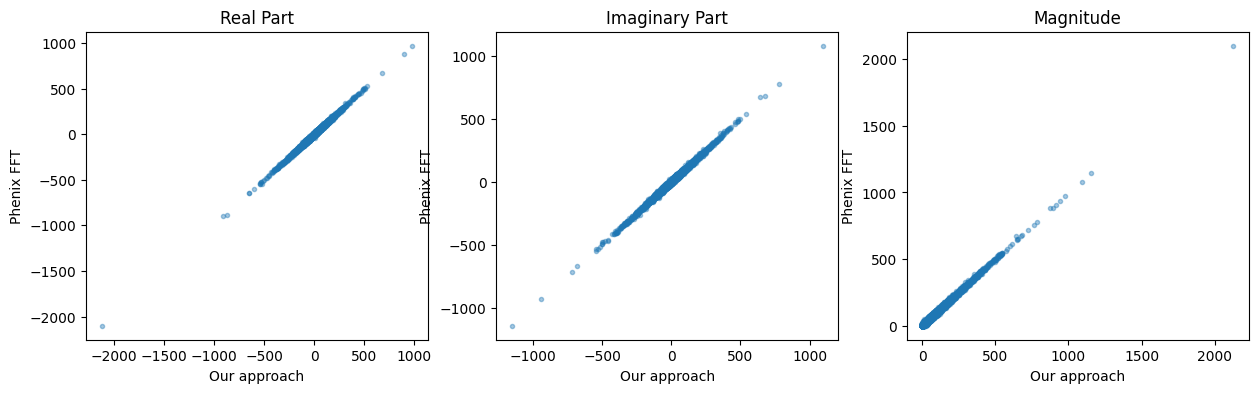

In [15]:
# Protein Part
comp_plot_complex(Fprotein_arr, Fcalc_complex, "Our approach", "Phenix FFT", dpi=100)

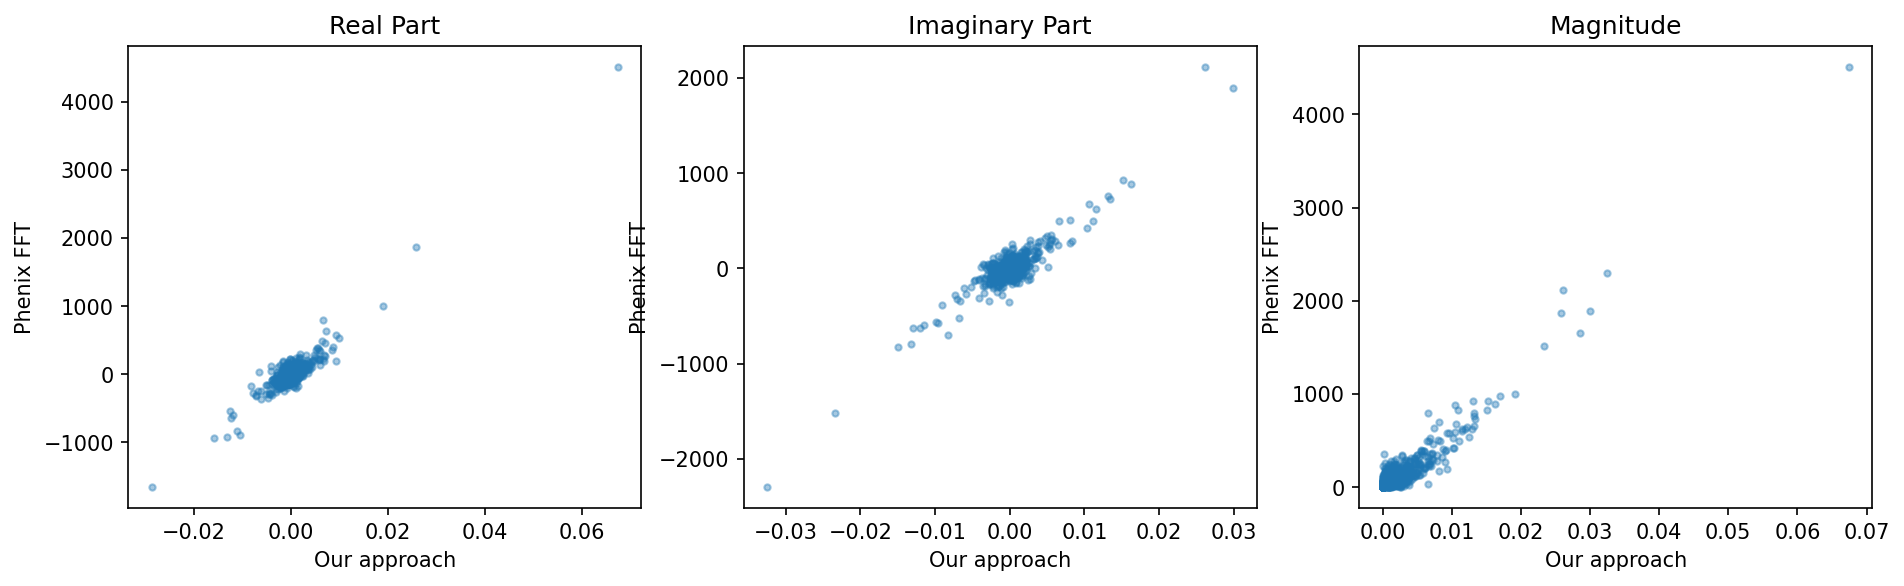

In [18]:
comp_plot_complex(Fsolvent.cpu(), Fmask_complex, "Our approach", "Phenix FFT", dpi=150)

#### Gradient descent for the scales

In [9]:
import torch
import time

In [10]:
from SFcalculator.utils import r_factor

In [11]:
kall = torch.tensor(0.5, device=try_gpu(), requires_grad=True)
kaniso = torch.normal(0.01, 0.01, size=[6], device=try_gpu(), requires_grad=True)
ksol = torch.tensor(0.1, device=try_gpu(), requires_grad=True)
bsol = torch.tensor(.0, device=try_gpu(), requires_grad=True)

In [12]:
params = [kall, kaniso, ksol, bsol]
optimizer = torch.optim.Adam(params, lr=0.01)

In [13]:
def scale_train(optimizer, sfcalculator, n_steps=1000, loss_track=[], verbose=True):
    def scale_steptrain(optimizer, sfcalculator):
        Fmodel = sfcalculator.Calc_Ftotal(kall=kall, kaniso=kaniso, ksol=ksol, bsol=bsol)
        Fmodel_mag = torch.abs(Fmodel)
        loss = torch.sum((sfcalculator.Fo - Fmodel_mag)**2)
        r_work, r_free = r_factor(sfcalculator.Fo, Fmodel_mag, sfcalculator.rwork_id, sfcalculator.rfree_id)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss, r_work, r_free
    for k in range(n_steps):
        start_time = time.time()

        temp = scale_steptrain(optimizer, sfcalculator)
        loss_track.append([i.detach().cpu().numpy() for i in temp])
        time_this_round = round(time.time() - start_time, 3)
        str_ = "Time: " + str(time_this_round)

        if verbose:
            print("Scale", *loss_track[-1], str_, flush=True)
    return loss_track

In [14]:
sfcalculator.Calc_Fprotein()
sfcalculator.Calc_Fsolvent(dmin_mask=6.0, dmin_nonzero=3.0)

In [15]:
loss_track = scale_train(optimizer, sfcalculator, n_steps=2000, loss_track=[], verbose=True)

Scale 38580424.06389595 0.5529676759581079 0.5602791863508962 Time: 0.038
Scale 35563403.29227079 0.5205238561223438 0.5282774113103529 Time: 0.008
Scale 32567479.082315847 0.48553062420157905 0.4938970085168543 Time: 0.006
Scale 29624980.879667994 0.4482857011217811 0.45777964656796616 Time: 0.005
Scale 26779127.817754395 0.4096237539384933 0.4209136870604673 Time: 0.004
Scale 24087126.455090746 0.37178887331797095 0.38528568365602106 Time: 0.004
Scale 21623479.75383025 0.33832176637601674 0.35479392455456416 Time: 0.003
Scale 19482619.1956254 0.31480720830848125 0.3340455406412581 Time: 0.003
Scale 17777901.921401866 0.3045245594438955 0.32589052133268614 Time: 0.003
Scale 16629615.768665921 0.30760153126509543 0.32866255346942846 Time: 0.003
Scale 16126721.411738724 0.3222765503333802 0.3431296519398561 Time: 0.003
Scale 16245173.870488003 0.34457694809842415 0.3661576841609197 Time: 0.003
Scale 16754990.119645305 0.36804095090618005 0.39097234548559795 Time: 0.003
Scale 17260992.89